In [1]:
import numpy as np
from numpy import random
import math
from matplotlib import pyplot as plt
from scipy import misc
import scipy
from util.rputil import *
from time import perf_counter
import pandas as pd
from tqdm import tqdm

# Random Decompositions

Low-rank matrix approximations are a powerful tool in data analysis and computing. This paper describes how randomization is used to create more efficient algorithms to perform low-rank matrix approximation. Compared to standard approaches, random algorithms are often faster and more robust. With these randomized algorithms the door is opened to deal with significantly large data sets.

As the SVD group can tell you, the Eckart-Young Theorem states that the first $k$ terms of the SVD represent the _best_ rank $k$ approximation to a matrix $A$. However, it is often computationally intractable to perform matrix factorization, as computational complexity of SVD is $O\left(\text{min}\{m^2n,n^2m\}\right)$. Thus, one important idea is using randomness to find matrices that approximate the original one but have significantly lower rank. These approximation matrices are easier to factor and use in numerical computations. 

When the dimension of our data, $n$, becomes very large, we may do this by exploiting the phenomenon of _concentration of measure_ (i.e. Johnson-Lindenstrauss Lemma).

# Johnson-Lindenstrauss Lemma

The Johnson-Lindenstrauss Lemma describes the existence of a map from a higher dimensional space $\mathbb{R}^d$ into a lower dimensional space $\mathbb{R}^k$ that preserves pairwise distances between the $n$ points up to an error tolerance $0<\varepsilon<1$, with $k$ on the order of $\varepsilon^{-2}\log n$. 

In applications with which we are concerned, the data (collection of points) can be viewed as a matrix $A\in \mathcal{M}_{m\times n}(\mathbb{R})$, with each row representing a point in $\mathbb{R}^n$, and the map in question may be taken to be a projection $P\in \mathcal{M}_{n\times k}(\mathbb{R})$.

#### Lemma (Johnson-Lindenstrauss)

Let $\{x_1,...,x_n\}$ be a collection of data points in $\mathbb{R}^d$. Let $k\in\mathbb{N}$ such that 
$$
k > C\cdot \log n \quad\quad \left(C= \frac{24}{3\varepsilon^2 - 2\varepsilon^3}\right)
$$
Then there exists a linear map $f$ (projection) such that for any $x_i,x_j\in X$,
$$
(1-\varepsilon)\,\|x_i-x_j\|_2^2 \leq \|f(x_i)-f(x_j)\|_2^2 \leq (1+\varepsilon)\,\|x_i-x_j\|_2^2
$$

We will not provide the full proof here, but part of a proof involves the following lemma:

Let $u\in \mathbb{R}^d$ be fixed, and let $R$ be a random matrix with $R_{ij} \sim N(0,1)$. Define $v=\frac{1}{\sqrt{k}}Ru$, such that $v\in\mathbb{R}^k$. Then
$$
\mathbb{E} \,[\|v\|_2^2] = \|u\|_2^2
$$

We provide intuition through an example:

Mean: -0.004359510386781798, Stdev: 0.4453629837950094


Text(0.5, 1.0, 'Error Between Squared Norms in High and Low Dimensional Spaces')

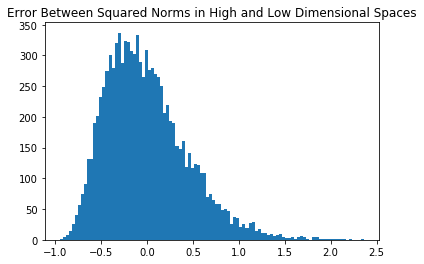

In [2]:
d = 1000
k = 10

u = random.randn(d,1)
u = u / np.linalg.norm(u)
u_squared_norm = np.sum(np.square(u))

iterations = 10000

v_list = np.empty(iterations)

for i in range(iterations):
    R = random.randn(k,d)
    v = 1/math.sqrt(k) * R @ u
    v_list[i] = np.sum(np.square(v))
v_delta = v_list - u_squared_norm

print(f'Mean: {np.mean(v_delta)}, Stdev: {np.std(v_delta)}')
a = plt.hist(v_delta, bins=100)
plt.title('Error Between Squared Norms in High and Low Dimensional Spaces')

From the histogram above and mean value, we can see that the lemma appears to hold up in practice

## Random Decompositions

Now let's explore various low-rank approximations. We will use two deterministic methods, and two random methods, and compare results. 

#### Interpolative Decomposition

Given $A \in \mathbb{R}^{m \times n}$, the $Q R$ decomposition essentially performs Gram-Schmidt on the columns of $A$. Furthermore, we can use a _pivoted_ version, which lets us select the _best $k$ columns_ from $Q$, also aiding in numerical stability. The column-pivoted $Q R$ decomposition computes
$$ AP = QR.$$
where $P$ is a permutation matrix.

#### Randomized Interpolative Decomposition

Instead of choosing the _best $k$ columns_ we can instead randomly sample $p>k$ columns from $A$, form the column-pivoted QR decomposition from these, and then take the first $k$ columns of $Q$, which gives us $Q_k$, which approximates $A$ as
$$ A \approx Q_k Q_k^* A $$

We will use the following image as an example:

In [3]:
mnist = pd.read_csv('../datasets/mnist/train.csv')
full_X = mnist[mnist.columns[1:]].values / 255
data = full_X[:5000]
#face = misc.face()
#plt.imshow(data)

## Rank 10 Approximations

Text(0.5, 0, 'Randomized ID')

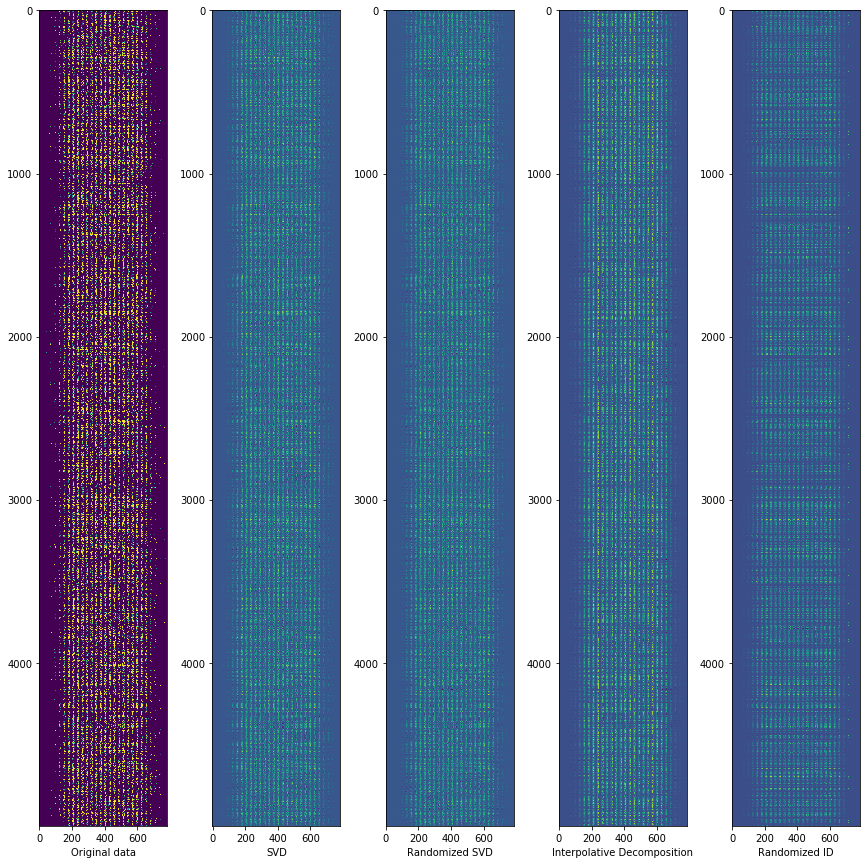

In [4]:
fig, ax = plt.subplots(1,5, figsize=(15,15))
ax[0].imshow(data)
ax[0].set_xlabel('Original data')
ax[1].imshow(svd_rank_k(data, 10))
ax[1].set_xlabel('SVD')
ax[2].imshow(random_svd_rank_k(data, 10))
ax[2].set_xlabel('Randomized SVD')
ax[3].imshow(id_rank_k(data, 10))
ax[3].set_xlabel('Interpolative Decomposition')
ax[4].imshow(random_id_rank_k(data, 10))
ax[4].set_xlabel('Randomized ID')


## Rank 128 Approximations

Text(0.5, 0, 'Randomized ID')

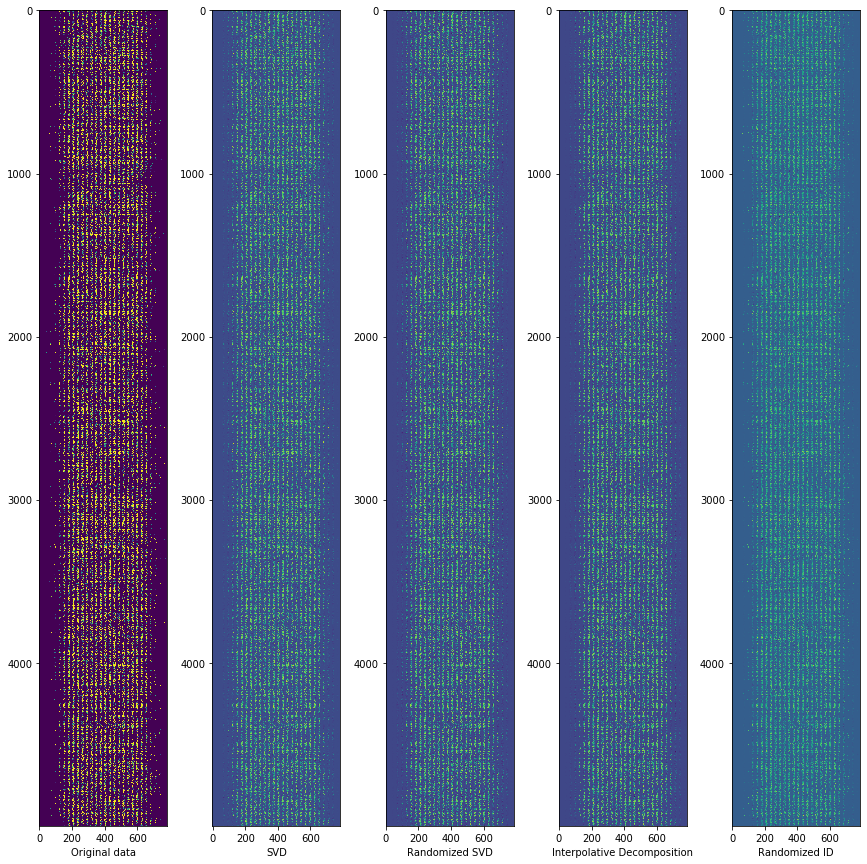

In [5]:
fig, ax = plt.subplots(1,5, figsize=(15,15))
ax[0].imshow(data)
ax[0].set_xlabel('Original data')
start = perf_counter()
ax[1].imshow(svd_rank_k(data, 128))
end = perf_counter()
t_svd = end-start
ax[1].set_xlabel('SVD')
start = perf_counter()
ax[2].imshow(random_svd_rank_k(data, 128))
end = perf_counter()
t_rsvd = end-start
ax[2].set_xlabel('Randomized SVD')
start = perf_counter()
ax[3].imshow(id_rank_k(data, 128))
end = perf_counter()
t_id = end-start
ax[3].set_xlabel('Interpolative Decomposition')
start = perf_counter()
ax[4].imshow(random_id_rank_k(data, 128))
end = perf_counter()
t_rid = end-start
ax[4].set_xlabel('Randomized ID')

In [6]:
k_domain = np.array([25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500])
error_svd = np.empty(k_domain.shape[0])
error_id = np.empty(k_domain.shape[0])
abs_svd = np.empty(k_domain.shape[0])
abs_id = np.empty(k_domain.shape[0])

for i,val in enumerate(k_domain):
    abs_svd[i] = np.linalg.norm(data - svd_rank_k(data, val))
    abs_id[i] = np.linalg.norm(data - id_rank_k(data, val))
    error_svd[i] =  abs_svd[i]/ np.linalg.norm(data)
    error_id[i] = abs_id[i]/ np.linalg.norm(data)

error_random_svd = np.empty((8,k_domain.shape[0]))
error_random_id = np.empty((8, k_domain.shape[0]))

iterations = 10

for i,val in enumerate(tqdm(k_domain)):
    err_rsvd = np.empty((iterations,2))
    err_rid = np.empty((iterations,2))
    for j in range(iterations):
        abs_rsvd = np.linalg.norm(data - random_svd_rank_k(data,val))
        abs_rid = np.linalg.norm(data - random_id_rank_k(data,val, int(np.log(val))))
        #abs_svd = np.linalg.norm(data - svd_rank_k(data,val))
        #abs_id = np.linalg.norm(data - id_rank_k(data,val))
        err_rsvd[j][0] = abs_rsvd / np.linalg.norm(data)
        err_rid[j][0] = abs_rid / np.linalg.norm(data)
        err_rsvd[j][1] = (abs_rsvd - abs_svd[i])/abs_svd[i]
        err_rid[j][1] = (abs_rid - abs_id[i])/abs_id[i]
    
    error_random_svd[0][i] = np.quantile(err_rsvd[:,0], 0.25)
    error_random_svd[1][i] = np.median(err_rsvd[:,0])
    error_random_svd[2][i] = np.quantile(err_rsvd[:,0], 0.75)
    error_random_svd[3][i] = np.mean(err_rsvd[:,0])
    error_random_svd[4][i] = np.std(err_rsvd[:,0])
    error_random_svd[5][i] = np.min(err_rsvd[:,0])
    error_random_svd[6][i] = np.max(err_rsvd[:,0])
    error_random_svd[7][i] = np.mean(err_rsvd[:,1])
   
    error_random_id[0][i] = np.quantile(err_rid[:,0], 0.25)
    error_random_id[1][i] = np.median(err_rid[:,0])
    error_random_id[2][i] = np.quantile(err_rid[:,0], 0.75)
    error_random_id[3][i] = np.mean(err_rid[:,0])
    error_random_id[4][i] = np.std(err_rid[:,0])
    error_random_id[5][i] = np.min(err_rid[:,0])
    error_random_id[6][i] = np.max(err_rid[:,0])
    error_random_id[7][i] = np.mean(err_rid[:,1])


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [10:17<00:00, 30.89s/it]


In [ ]:
time_did = np.empty(k_domain.shape[0])
time_dsvd = np.empty(k_domain.shape[0])
time_rsvd = np.empty(k_domain.shape[0])
time_rid = np.empty(k_domain.shape[0])

N = 10 # Number of iterations to mitigate caching effects

for i,val in enumerate(tqdm(k_domain)):
    #time svd
    start = perf_counter()
    for n in range(N):
        svd_rank_k(data,val)
    end = perf_counter()
    time_dsvd[i] = (end - start)/N
    #time id
    start = perf_counter()
    for n in range(N):
        id_rank_k(data,val)
    end = perf_counter()
    time_did[i] = (end - start)/N
    #time rsvd
    start = perf_counter()
    for n in range(N):
        random_svd_rank_k(data, val)
    end = perf_counter()
    time_rsvd[i]= ((end - start)/N)/time_dsvd[i]
    #time rid
    start = perf_counter()
    for n in range(N):
        random_id_rank_k(data,val,int(np.log(val)))
    end = perf_counter()
    time_rid[i] = ((end - start)/N)/time_did[i]   

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [26:00<01:28, 88.03s/it]

## Results

Finally, we will compare accuracies of various approximation methods, and look at statistics of the randomized methods

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].plot(k_domain, error_svd, c='b', label='SVD')
ax[0].plot(k_domain, error_id, c='r', label='ID')
ax[0].plot(k_domain, error_random_svd[3], c='c', label='mean RSVD')
ax[0].plot(k_domain, error_random_id[3], c='m', label='mean RID')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error, log scale')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Error in Various Approximations')

ax[1].plot(k_domain, error_random_svd[1], c='b', label='Median')
ax[1].fill_between(k_domain, error_random_svd[6],error_random_svd[5], alpha=0.2, label='Range')
ax[1].fill_between(k_domain, error_random_svd[2],error_random_svd[0], alpha=0.5, label='IQR')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Relative Error, log scale')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Randomized SVD \'continuous boxplot\'')

ax[2].plot(k_domain, error_random_id[1], c='b', label='Median')
ax[2].fill_between(k_domain, error_random_id[6],error_random_id[5], alpha=0.2, label='Range')
ax[2].fill_between(k_domain, error_random_id[2],error_random_id[0], alpha=0.5, label='IQR')
ax[2].set_xlabel('k')
ax[2].set_ylabel('Relative Error, log scale')
ax[2].set_yscale('log')
ax[2].legend(loc='upper right')
ax[2].set_title('Randomized ID \'continuous boxplot\'')

plt.show()

In [ ]:
#fig, ax = plt.subplots(figsize=(10,5))

#ax.set_xlabel('k')

#ax.plot(k_domain, time_rid, label='')
#ax.set_ylabel('Relative Error')

#ax2=ax.twinx()

#fig.legend(loc='upper right')

In [ ]:
print(f'For k={k_domain[4]}, RSVD error: mean = {error_random_svd[3][4]}, stdev = {error_random_svd[4][4]}')
print(f'For k={k_domain[4]}, RID error: mean = {error_random_id[3][4]}, stdev = {error_random_id[4][4]}')
print(f'For k={k_domain[4]}, SVD error: {error_svd[4]}, stdev = {error_svd[4]}')
print(f'For k={k_domain[4]}, ID error:  {error_id[4]}, stdev = {error_id[4]}')

In [ ]:
for i in range(k_domain.size):
    print(f'For k={k_domain[i]}, RSVD time is: ',time_rsvd[i]*time_dsvd[i])
    print(f'For k={k_domain[i]}, SVD time is: ',time_dsvd[i])
    print(f'For k={k_domain[i]}, RID time is: ',time_rid[i]*time_did[i])
    print(f'For k={k_domain[i]}, ID time is: ',time_did[i])
    print('New k')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(k_domain, error_random_id[7], c='m',label = 'Error')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
#ax[0].set_yscale('log')
ax[0].set_title('Random ID Error and Time Relative to Deterministic ID')
ax1=ax[0].twinx()
ax1.set_ylabel('Relative Time')
ax1.plot(k_domain,time_rid,c='b',label = 'Time')


ax[1].plot(k_domain, error_random_svd[7], c='m',label = 'Error')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Relative Error')
#ax[0].set_yscale('log')
ax[1].set_title('Random SVD Error and Time Relative to Deterministic SVD')
ax2=ax[1].twinx()
ax2.set_ylabel('Relative Time')
ax2.plot(k_domain,time_rsvd,c='b',label = 'Time')
